In [120]:
import os, ast, random, time
import numpy as np
import pandas as pd
import wfdb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from ptbxl_utils import setup_dataset, load_ecg
import random

**Reproducibility Setup**  
To ensure consistent and repeatable results across runs, we set a fixed random  
seed for Python, NumPy, and PyTorch. This helps guarantee that model initialization,  
data shuffling, and other random operations produce the same outcomes every time the notebook is executed.

In [121]:
# Set random seed for reproducibility across Python, NumPy and PyTorch
# Keeps model results consistent and reproducible
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f" Random seed set to {seed}\n")

set_seed(42)
SEED = 42  # Keep SEED defined for consistency (used later)

 Random seed set to 42



In [122]:
data_path = "ptb-xl-dataset-1.0.3"
csv_path = os.path.join(data_path, "ptbxl_database.csv")
df = pd.read_csv(csv_path)

**Dataset Setup and Initialization**  
Load the PTB-XL metadata, select training, validation, and test folds, set the ECG sampling  
frequency (100Hz or 500Hz), and choose between filtered (AFIB vs NORM) or unfiltered   
(AFIB vs ALL other classes) dataset modes. The PTB-XL dataset is pre-divided into 10  
 stratified folds (1–10).One or multiple folds can be selected for each split — for example:    
rain_folds = [1, 2, 3]  
val_folds = [9]  
test_folds = [10]


In [ ]:


# dataset config
use_500Hz = False          # True: 500Hz | False: 100Hz
use_filtered = True        # True: AFIB vs NORM, False: AFIB vs ALL

data_path = "ptb-xl-dataset-1.0.3"
csv_path = os.path.join(data_path, "ptbxl_database.csv")
df = pd.read_csv(csv_path)

train_data, val_data, test_data, freq = setup_dataset(
    df,
    train_folds=[1,2,3],
    val_folds=[9],
    test_folds=[10],
    use_500Hz=use_500Hz,
    use_filtered=use_filtered
)


#  ECG Load Test
sample_path = train_data.iloc[0]["filename"]
signal, info = load_ecg(sample_path, base_dir=data_path, return_meta=True)

# Verify ECG Record Loading
print("Signal shape:", signal.shape)
print("Metadata:", info)


Selected folds:
 Train: Fold [1] (1086 samples)
 Validation: Fold [9] (1102 samples)
 Test: Fold [10] (1112 samples)
 Total: 3300 samples

Selected ECG sampling rate: 100Hz
Selected dataset mode: Filtered (AFIB vs NORM)
Train      | AFIB: 151    | NORM: 935    | Total: 1086   | AFIB%: 13.90%
Validation | AFIB: 151    | NORM: 951    | Total: 1102   | AFIB%: 13.70%
Test       | AFIB: 152    | NORM: 960    | Total: 1112   | AFIB%: 13.67%

Totals:
 AFIB: 454    | NORM: 2846   | Total: 3300   | AFIB%: 13.76%

Signal shape: (1000, 12)
Metadata: {'fs': 100, 'leads': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']}


#### Create PyTorch Datasets class and DataLoaders  
This section defines the PTBXL_Dataset class — a custom PyTorch dataset for dynamically loading  
ECG signals from the PTB-XL dataset.Each ECG record is loaded using load_ecg(), normalized per   
lead, and returned as a (signal, label) tensor pair for model training.  
Automatically loads ECG files from disk using their paths in the metadata.  
Normalizes each lead using the training split’s mean and standard deviation.  
Returns data in the correct shape (12, L) for CNN input.  
Can be used directly with PyTorch’s DataLoader for efficient batching and shuffling.  

In [124]:
# 7. PyTorch Dataset class
class PTBXL_Dataset(Dataset):
    """Custom dataset: loads ECG signals, normalizes per-lead, returns (tensor, label)."""
    def __init__(self, df_split, base_dir, mean=None, std=None):
        # Store ECG file paths and labels from the DataFrame
        self.paths = df_split["filename"].values
        self.labels = df_split["label"].astype(np.float32).values
        self.base_dir = base_dir

        # Compute normalization stats (mean, std) if not provided
        if mean is None or std is None:
            samp = df_split.sample(min(100, len(df_split)), random_state=SEED)["filename"]
            cat = np.concatenate([load_ecg(p, base_dir=self.base_dir) for p in samp], axis=0)
            self.mean = cat.mean(axis=0)
            self.std  = cat.std(axis=0) + 1e-7
        else:
            # Reuse mean/std from training split for val/test
            self.mean, self.std = mean, std

    # Return number of samples in the dataset
    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):      # idx = index of one ECG record
        # Load ECG signal as NumPy array
        arr = load_ecg(self.paths[idx], base_dir=self.base_dir)
        # Normalize each lead using precomputed mean/std
        arr = (arr - self.mean) / self.std
        # Convert to PyTorch tensor and reorder shape → (channels=12, length)
        arr = torch.from_numpy(arr.T).float()  # (12, L)
        # Get label (0 or 1) as PyTorch tensor
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return arr, label           # Return signal and label pair

**DataLoaders**  
We create PyTorch Dataset and DataLoader objects for the training, validation, and test splits.  
The training set computes normalization statistics (mean and standard deviation), which are reused  
by validation and test sets for consistency.  
DataLoader handles batching, shuffling, and efficient loading.  
Finally, a quick sanity check fetches one batch to confirm signal and label shapes.  

In [125]:
# Check if GPU (CUDA) is available for faster training
use_cuda = torch.cuda.is_available()

# Create PyTorch Dataset objects for each data split
# Training computes mean/std; validation and test reuse them for consistency
train_set = PTBXL_Dataset(train_data, base_dir=data_path)
val_set   = PTBXL_Dataset(val_data, base_dir=data_path, mean=train_set.mean, std=train_set.std)
test_set  = PTBXL_Dataset(test_data, base_dir=data_path, mean=train_set.mean, std=train_set.std)

# Wrap datasets into DataLoaders for batching and efficient loading
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0, pin_memory=use_cuda)
val_loader   = DataLoader(val_set,   batch_size=16, shuffle=False, num_workers=0, pin_memory=use_cuda)
test_loader  = DataLoader(test_set,  batch_size=16, shuffle=False, num_workers=0, pin_memory=use_cuda)

# Prints whether DataLoaders are configured for GPU or CPU use.
print(f"DataLoaders ready (GPU = {use_cuda})\n")

# Fetch one batch and show signal and label shapes
batch = next(iter(train_loader))
print(batch[0].shape, batch[1].shape)



DataLoaders ready (GPU = False)

torch.Size([16, 12, 1000]) torch.Size([16])


### Define a simple 1D CNN Model for ECG Classification  
This CNN extracts temporal features from 12-lead ECG signals using three convolutional layers with pooling.  
It automatically adapts to input length (100 Hz or 500 Hz), flattens the features, and classifies each signal  
as AFIB or NORM using fully connected layers. Training uses Binary Cross-Entropy with Logits loss and the Adam optimizer. 

In [126]:
#CNN model (auto-adapts to input length)
class CNN1D(nn.Module):
    # input_length: the ECG signal length (1000 for 100Hz or 5000 for 500Hz).
    def __init__(self, input_length, in_channels=12):
        super().__init__()

        # Convolutional feature extractor
        # Conv1d: learns filters to detect waveform features (like peaks or rhythm changes).
        # ReLU: introduces non-linearity.
        # MaxPool1d(2): halves the signal length each time (downsampling).
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32), 
            nn.ReLU(), 
            nn.MaxPool1d(2),

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64), 
            nn.ReLU(), 
            nn.MaxPool1d(2),

            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(), 
            nn.MaxPool1d(2),
        )

        # Dynamically compute flatten dimension(number of features (numbers) that go into the first fully connected layer) based on input length
        # Automatically adapts to 100Hz or 500Hz ECG signal lengths
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, input_length)
            conv_out = self.conv_layers(dummy)
            flat_dim = conv_out.shape[1] * conv_out.shape[2]
        print(f"Detected flatten dimension: {flat_dim} for input length {input_length}")

        # or New flat_dim is simply the last out_channels number
        """"
        flat_dim = 128 
        print(f"Global Pool flat dimension: {flat_dim}")
        """
        # Fully connected classification head
        # Maps extracted features to binary output (AFIB vs NORM)
        self.fc_layers = nn.Sequential(
            nn.Linear(flat_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # Forward pass: convolution → flatten → classification
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)


# Model Initialization and Setup
# Automatically pick input length based on dataset frequency (100Hz or 500Hz)
INPUT_LEN = 5000 if freq == 500 else 1000
model = CNN1D(input_length=INPUT_LEN)
device = torch.device("cuda" if use_cuda else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(f"Model created for input length {INPUT_LEN}, running on {device}\n")


Detected flatten dimension: 16000 for input length 1000
Model created for input length 1000, running on cpu



##### Define training and evaluation function

In [127]:
# Train the model for one epoch.
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train(); total_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y.unsqueeze(1))  # binary case
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

# Evaluate the model on validation/test data.
def evaluate_model(model, loader, criterion, device, threshold=0.5):
    model.eval(); total_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y.unsqueeze(1))
            total_loss += loss.item() * x.size(0)
            probs = torch.sigmoid(out)
            preds = (probs > threshold).squeeze(1).long()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute metrics
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, f1, acc, np.array(y_true), np.array(y_pred)


#### Implement the training process

In [128]:
# Training loop
start_time = time.time()
NUM_EPOCHS = 10
best_f1 = 0.0; best_state = None

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_f1, val_acc, y_true, y_pred = evaluate_model(model, val_loader, criterion, device)
    print(f"  Train Loss {tr_loss:.4f} | Val Loss {val_loss:.4f} | Val F1 {val_f1:.4f} | Val Acc {val_acc:.4f}")
    if val_f1 > best_f1:
        best_f1 = val_f1; best_state = model.state_dict()
        print("  New model saved\n")

if best_state:
    model.load_state_dict(best_state)
    print("Best model (highest Val F1) re-loaded.\n")

Epoch 1/10
  Train Loss 0.5075 | Val Loss 0.1753 | Val F1 0.7509 | Val Acc 0.9374
  New model saved

Epoch 2/10
  Train Loss 0.2033 | Val Loss 0.1571 | Val F1 0.8100 | Val Acc 0.9519
  New model saved

Epoch 3/10
  Train Loss 0.1360 | Val Loss 0.2133 | Val F1 0.6463 | Val Acc 0.9265
Epoch 4/10
  Train Loss 0.1175 | Val Loss 0.2195 | Val F1 0.7528 | Val Acc 0.9201
Epoch 5/10
  Train Loss 0.1102 | Val Loss 0.2286 | Val F1 0.7829 | Val Acc 0.9492
Epoch 6/10
  Train Loss 0.0831 | Val Loss 0.1385 | Val F1 0.8472 | Val Acc 0.9601
  New model saved

Epoch 7/10
  Train Loss 0.0775 | Val Loss 0.2019 | Val F1 0.7619 | Val Acc 0.9456
Epoch 8/10
  Train Loss 0.0862 | Val Loss 0.1797 | Val F1 0.8406 | Val Acc 0.9601
Epoch 9/10
  Train Loss 0.0502 | Val Loss 0.1857 | Val F1 0.8086 | Val Acc 0.9437
Epoch 10/10
  Train Loss 0.0408 | Val Loss 0.2027 | Val F1 0.8495 | Val Acc 0.9592
  New model saved

Best model (highest Val F1) re-loaded.



#### Evaluate the final model

In [129]:
# Evaluate on the Test Set (Updated for filtered/unfiltered modes) 
test_loss, test_f1, test_acc, y_true, y_pred = evaluate_model(model, test_loader, criterion, device)

print("\n=== Test Metrics Summary ===")
print(f"  Test Loss:     {test_loss:.4f}")
print(f"  Test F1-score: {test_f1:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Sampling frequency: {freq} Hz")
print(f"  Device used: {'GPU' if device.type == 'cuda' else 'CPU'}")

# Switch model to eval mode
model.eval()

# Label mapping 
print("\nLabel mapping:")
if 'use_filtered' in globals() and use_filtered:
    print("0: Normal Sinus Rhythm (NORM)")
    print("1: Atrial Fibrillation (AFIB)")
else:
    print("0: All other rhythms (non-AFIB)")
    print("1: Atrial Fibrillation (AFIB)")

#  Detailed classification report
print("\nClassification Report:")
if 'use_filtered' in globals() and use_filtered:
    target_names = ["Normal", "AFIB"]
else:
    target_names = ["Other rhythms", "AFIB"]

print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

tn, fp, fn, tp = cm.ravel()
total_neg = cm[0].sum()
total_pos = cm[1].sum()

if 'use_filtered' in globals() and use_filtered:
    neg_label, pos_label = "Normal ECGs", "AFIB ECGs"
else:
    neg_label, pos_label = "Other (non-AFIB) ECGs", "AFIB ECGs"

print(f"{tn} {neg_label} correctly classified ({tn/total_neg*100:.1f}%)")
print(f"{fp} {neg_label} wrongly predicted as AFIB ({fp/total_neg*100:.1f}%) [False Positives]")
print(f"{tp} {pos_label} correctly classified ({tp/total_pos*100:.1f}%)")
print(f"{fn} {pos_label} wrongly predicted as non-AFIB ({fn/total_pos*100:.1f}%) [False Negatives]")

# Dataset Summary
print("\nDataset Sizes:")
print(f"  Training records:   {len(train_data)}")
print(f"  Validation records: {len(val_data)}")
print(f"  Test records:       {len(test_data)}")

# Runtime Summary
end_time = time.time()
total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"\nRuntime: {int(hours):02d}h {int(minutes):02d}m {int(seconds):02d}s")



=== Test Metrics Summary ===
  Test Loss:     0.1972
  Test F1-score: 0.8389
  Test Accuracy: 0.9568
  Sampling frequency: 100 Hz
  Device used: CPU

Label mapping:
0: Normal Sinus Rhythm (NORM)
1: Atrial Fibrillation (AFIB)

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.98       960
        AFIB       0.86      0.82      0.84       152

    accuracy                           0.96      1112
   macro avg       0.91      0.90      0.91      1112
weighted avg       0.96      0.96      0.96      1112

Confusion Matrix:
[[939  21]
 [ 27 125]]
939 Normal ECGs correctly classified (97.8%)
21 Normal ECGs wrongly predicted as AFIB (2.2%) [False Positives]
125 AFIB ECGs correctly classified (82.2%)
27 AFIB ECGs wrongly predicted as non-AFIB (17.8%) [False Negatives]

Dataset Sizes:
  Training records:   1086
  Validation records: 1102
  Test records:       1112

Runtime: 00h 01m 23s


**Grad-CAM Explainability**  
Grad-CAM tells you which parts of your ECG the model "looked at" when making its prediction.  
The red signal shows where the CNN’s final convolutional filters had the strongest gradient influence on the output.

In [130]:

class GradCAM1D:
    """
    Computes Grad-CAM for 1D convolutional models (e.g., CNN1D, UNet1D)
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, x, class_idx=None):
        """
        Forward + backward to compute Grad-CAM
        Returns 1D importance map (numpy array)
        """
        self.model.zero_grad()
        x = x.clone().detach().requires_grad_(True)
        logits = self.model(x)

        if class_idx is None:
            class_idx = 0  # for binary classifier (AFIB score)

        score = logits[:, class_idx].sum()
        score.backward(retain_graph=True)

        # Global average pooling of gradients -> importance weights
        weights = self.gradients.mean(dim=2, keepdim=True)  # [B, C, 1]
        cam = (weights * self.activations).sum(dim=1)       # [B, L]
        cam = F.relu(cam)
        cam = cam / (cam.max(dim=1, keepdim=True)[0] + 1e-8)
        return cam.detach().cpu().numpy(), logits.detach().cpu()


# Multi-lead Grad-CAM Plot (12 leads)
def plot_gradcam_12leads(ecg_tensor, cam, title="Grad-CAM (12-lead ECG)", figsize=(14,10)):
    """
    ecg_tensor: torch tensor [1, 12, L]
    cam: np.array [1, L_cam]
    """
    ecg_np = ecg_tensor[0].cpu().numpy()     # (12, L)
    cam_np = cam[0]

    # Interpolate CAM to ECG length
    if len(cam_np) != ecg_np.shape[1]:
        cam_np = np.interp(np.arange(ecg_np.shape[1]),
                           np.linspace(0, ecg_np.shape[1]-1, len(cam_np)),
                           cam_np)

    # Normalize CAM to 0–1
    cam_np = (cam_np - cam_np.min()) / (cam_np.max() + 1e-8)

    leads = [f"Lead {i+1}" for i in range(ecg_np.shape[0])]
    fig, axes = plt.subplots(6, 2, figsize=figsize, sharex=True)
    axes = axes.flatten()

    for i in range(12):
        ecg_lead = ecg_np[i]
        axes[i].plot(ecg_lead, color='b', linewidth=0.8)
        axes[i].fill_between(np.arange(len(ecg_lead)),
                             0,
                             cam_np * ecg_lead.max(),
                             color='r', alpha=0.25)
        axes[i].set_title(leads[i], fontsize=10)
        axes[i].set_ylim(ecg_lead.min()*1.2, ecg_lead.max()*1.2)
        axes[i].grid(alpha=0.3)

    fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return cam_np  # return for interpretation

# Single-lead Grad-CAM Plot (overlay style)
def plot_gradcam_singlelead(ecg_tensor, cam, lead=0, title="Grad-CAM (Single Lead)", figsize=(12,4), save_path=None):
    """Plots one lead with Grad-CAM overlay (blue ECG, red importance curve)."""
    ecg_np = ecg_tensor[0, lead].cpu().numpy()
    cam_np = cam[0]
    if len(cam_np) != len(ecg_np):
        cam_np = np.interp(np.arange(len(ecg_np)),
                           np.linspace(0, len(ecg_np)-1, len(cam_np)),
                           cam_np)
    cam_np = (cam_np - cam_np.min()) / (cam_np.max() + 1e-8)

    plt.figure(figsize=figsize)
    plt.plot(ecg_np, color='b', label='ECG')
    plt.plot(cam_np * ecg_np.max(), color='r', label='Grad-CAM', alpha=0.8)
    plt.title(title)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude / Importance")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f"Saved Grad-CAM figure → {save_path}")

    plt.show()


# Automatic Text Interpretation
def interpret_gradcam(cam_np, num_segments=10):
    """
    Provides textual interpretation of Grad-CAM 1D importance map.
    Splits signal into segments and finds which parts have highest focus.
    """
    L = len(cam_np)
    seg_len = L // num_segments
    segment_strengths = [
        cam_np[i*seg_len:(i+1)*seg_len].mean()
        for i in range(num_segments)
    ]
    top_segments = np.argsort(segment_strengths)[-3:][::-1] + 1  # top 3
    print("\nGrad-CAM Interpretation:")
    print(f"- Model focused most strongly around signal segments: {list(top_segments)} (out of {num_segments})")
    print("- High red intensity → important for prediction.")
    print("- Irregular, scattered peaks → AFIB; rhythmic periodic peaks → Normal Sinus Rhythm.")


# Run Grad-CAM on one ECG sample
# Pick the target layer for your model
target_layer = model.conv_layers[-4]  # For CNN1D
# target_layer = model.up4.conv.block[-1]  # For UNet1D

gradcam = GradCAM1D(model, target_layer)




In [131]:

# ECG Sample Selector — for CNN1D Grad-CAM

import random
import torch

def select_ecg_sample(test_loader, manual_index=None, show_list=False, num_show=10, device='cpu'):
    """
    Selects one ECG sample from the test set.
    - manual_index: int (pick specific ECG index)
    - show_list: if True, prints a few available indices + true labels
    - num_show: how many samples to list
    - device: 'cuda' or 'cpu'
    Returns: (x, y, idx, label_str)
    """
    dataset = test_loader.dataset
    n_total = len(dataset)

    if show_list:
        print(f"Test dataset has {n_total} samples.")
        print("Showing first few indices and labels:")
        for i in range(min(num_show, n_total)):
            _, y_i = dataset[i]
            label = "AFIB" if int(y_i.item()) == 1 else "Normal"
            print(f"   #{i:3d} → {label}")
        print("------------------------------------------------------")

    if manual_index is None:
        idx = random.randint(0, n_total - 1)
        mode = "Random"
    else:
        idx = int(manual_index)
        mode = "Manual"

    x, y = dataset[idx]
    x = x.unsqueeze(0).to(device)
    y = y.unsqueeze(0)

    label_str = "AFIB" if y.item() == 1 else "Normal Sinus Rhythm"

    print(f"{mode} selection → Test sample #{idx}")
    print(f"   True label: {label_str} (y={int(y.item())})")

    return x, y, idx, label_str

# --- Example use ---
# manual_index = 42  # Uncomment to pick a specific ECG
manual_index = None   # or None for random ECG
x, y, idx, label_str = select_ecg_sample(
    test_loader,
    manual_index=manual_index,
    show_list=True,     # shows a few available indices
    num_show=10,
    device=device
)


Test dataset has 1112 samples.
Showing first few indices and labels:
   #  0 → Normal
   #  1 → Normal
   #  2 → Normal
   #  3 → Normal
   #  4 → Normal
   #  5 → Normal
   #  6 → Normal
   #  7 → Normal
   #  8 → Normal
   #  9 → Normal
------------------------------------------------------
Random selection → Test sample #228
   True label: Normal Sinus Rhythm (y=0)



 Model Prediction (CNN1D): Normal Sinus Rhythm
   Confidence: 0.000


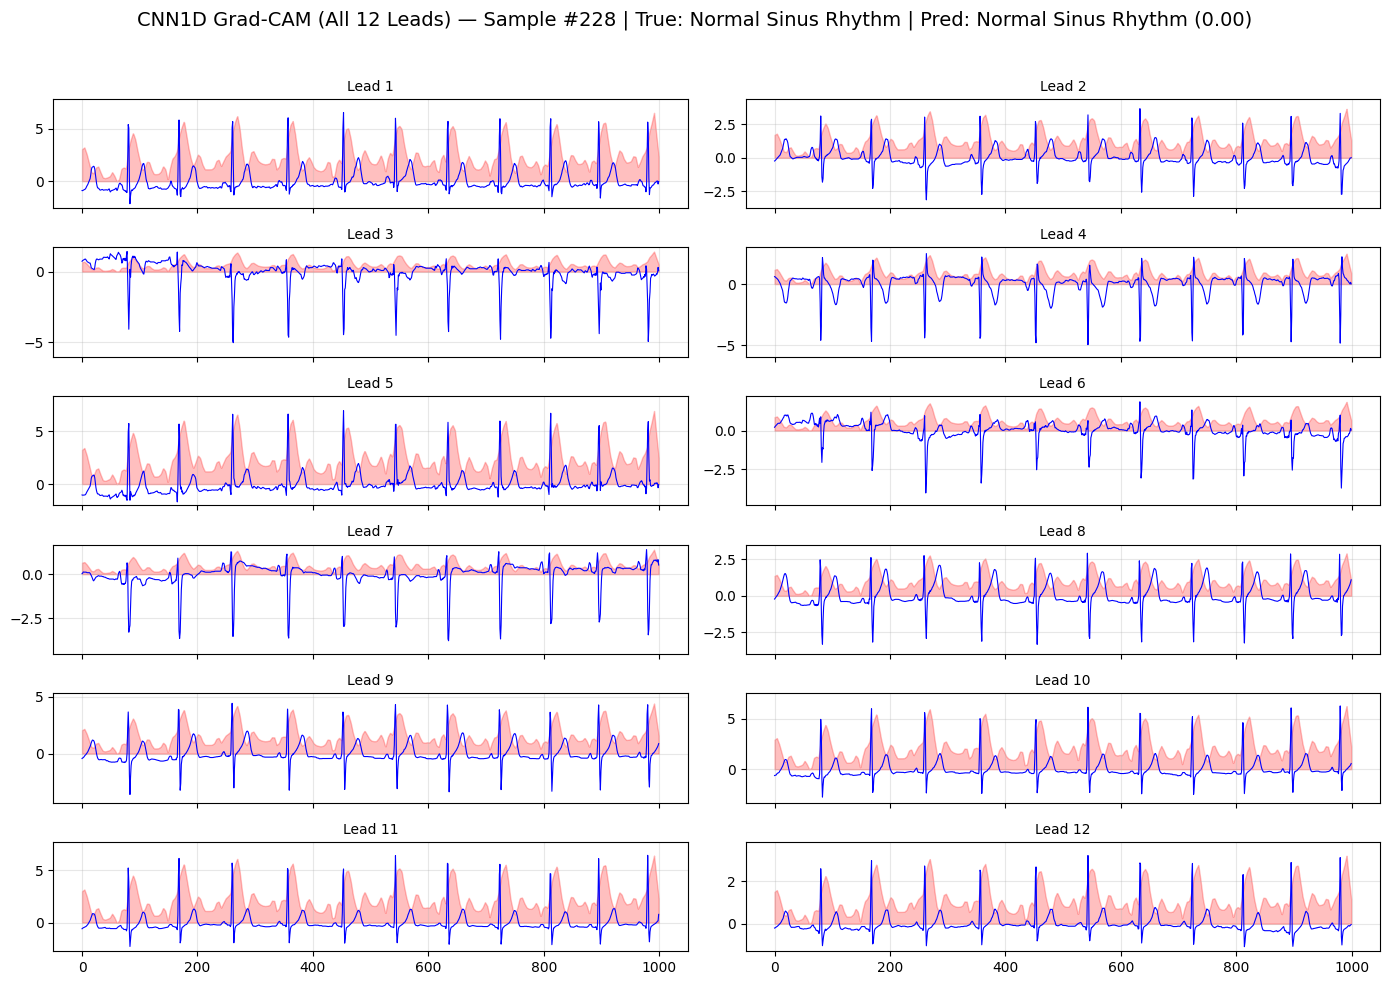

Saved Grad-CAM figure → gradcam_results/sample_228_cnn_lead1.png


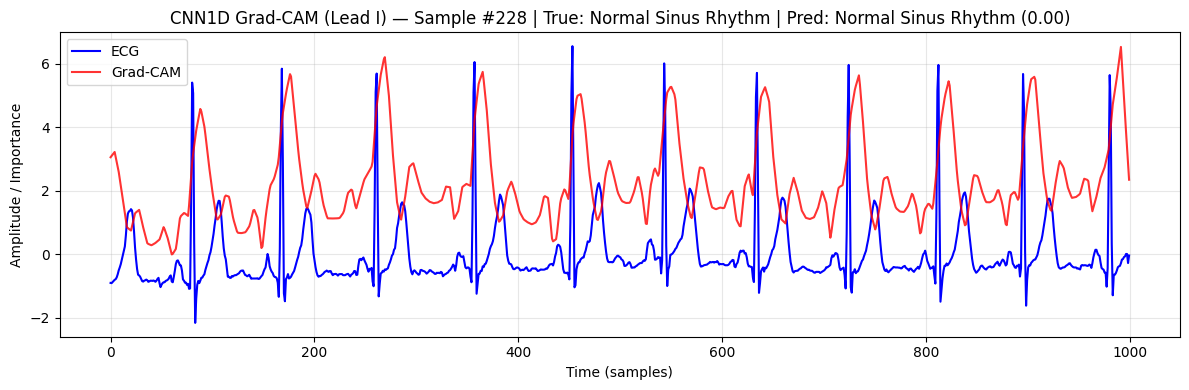


Grad-CAM Interpretation:
- Model focused most strongly around signal segments: [np.int64(10), np.int64(3), np.int64(6)] (out of 10)
- High red intensity → important for prediction.
- Irregular, scattered peaks → AFIB; rhythmic periodic peaks → Normal Sinus Rhythm.


In [132]:

# Grad-CAM Visualization — CNN1D

# Ensure GradCAM1D, plot_gradcam_12leads, plot_gradcam_singlelead, interpret_gradcam
# are already defined from your earlier Grad-CAM setup

# Target Layer
target_layer = model.conv_layers[-4]   # last Conv1D in CNN1D
gradcam = GradCAM1D(model, target_layer)

# Compute Grad-CAM
cam, logits = gradcam.generate(x)
prob = torch.sigmoid(logits).item()
pred_label = "AFIB" if prob >= 0.5 else "Normal Sinus Rhythm"

# Output Summary
print(f"\n Model Prediction (CNN1D): {pred_label}")
print(f"   Confidence: {prob:.3f}")

# Plot Grad-CAM
title_base = f"Sample #{idx} | True: {label_str} | Pred: {pred_label} ({prob:.2f})"

cam_np = plot_gradcam_12leads(
    x, cam, title=f"CNN1D Grad-CAM (All 12 Leads) — {title_base}"
)

plot_gradcam_singlelead(
    x, cam, lead=0,
    title=f"CNN1D Grad-CAM (Lead I) — {title_base}",
    save_path=f"gradcam_results/sample_{idx}_cnn_lead1.png"
)

# Interpretation
interpret_gradcam(cam_np)


## Re-evaluate the model on a new fold or frequency


In [136]:
# --- Re-evaluate trained CNN model on different folds or settings ---

# Example: choose new folds / settings
new_train_fold = [1]
new_val_fold   = [9]
new_test_fold  = [10]
use_500Hz      = False       # or True for 500 Hz signals
use_filtered   = True        # True: only AFIB vs NORM, False: all diagnoses

print(f"\nLoading new fold configuration: train={new_train_fold}, val={new_val_fold}, test={new_test_fold}")
print(f"Sampling frequency: {'500 Hz' if use_500Hz else '100 Hz'} | Filtered: {use_filtered}")

# --- Load new split ---
train_data, val_data, test_data, freq = setup_dataset(
    df,
    train_folds=new_train_fold,
    val_folds=new_val_fold,
    test_folds=new_test_fold,
    use_500Hz=use_500Hz,
    use_filtered=use_filtered
)

# --- Build datasets and loaders using same normalization as before ---
train_set = PTBXL_Dataset(train_data, base_dir=data_path)
val_set   = PTBXL_Dataset(val_data, base_dir=data_path, mean=train_set.mean, std=train_set.std)
test_set  = PTBXL_Dataset(test_data, base_dir=data_path, mean=train_set.mean, std=train_set.std)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0, pin_memory=use_cuda)
val_loader   = DataLoader(val_set,   batch_size=16, shuffle=False, num_workers=0, pin_memory=use_cuda)
test_loader  = DataLoader(test_set,  batch_size=16, shuffle=False, num_workers=0, pin_memory=use_cuda)

print(f"Data reloaded with new folds. Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")

# --- Evaluate the already-trained model on this new test fold ---
test_loss, test_f1, test_acc, y_true, y_pred = evaluate_model(model, test_loader, criterion, device)

print("\n=== Re-Evaluation Metrics ===")
print(f"  Test Loss:     {test_loss:.4f}")
print(f"  Test F1-score: {test_f1:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Sampling frequency: {freq} Hz")
print(f"  Device used: {'GPU' if device.type == 'cuda' else 'CPU'}")

# --- Classification report + confusion matrix ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'AFIB']))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)



Loading new fold configuration: train=[1], val=[9], test=[10]
Sampling frequency: 100 Hz | Filtered: True
Selected folds:
 Train: Fold [1] (1086 samples)
 Validation: Fold [9] (1102 samples)
 Test: Fold [10] (1112 samples)
 Total: 3300 samples

Selected ECG sampling rate: 100Hz
Selected dataset mode: Filtered (AFIB vs NORM)
Train      | AFIB: 151    | NORM: 935    | Total: 1086   | AFIB%: 13.90%
Validation | AFIB: 151    | NORM: 951    | Total: 1102   | AFIB%: 13.70%
Test       | AFIB: 152    | NORM: 960    | Total: 1112   | AFIB%: 13.67%

Totals:
 AFIB: 454    | NORM: 2846   | Total: 3300   | AFIB%: 13.76%

Data reloaded with new folds. Train=1086, Val=1102, Test=1112

=== Re-Evaluation Metrics ===
  Test Loss:     0.1972
  Test F1-score: 0.8389
  Test Accuracy: 0.9568
  Sampling frequency: 100 Hz
  Device used: CPU

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.98       960
        AFIB       0.86      0.82    